# Setup

## Import Libraries

- `from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions` 부분은 모델에 따라 변경 필요
- ex) Xception 모델 사용시
    - `from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions` 으로 변경

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.framework import convert_to_constants
from tensorflow.keras.preprocessing import image

#  model 에 따라 변경
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

## Get Data

예제 실행에서 사용하는 이미지 다운로드

In [2]:
!mkdir data

!wget  -O data/img0.JPG "https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630"
!wget  -O data/img1.JPG "https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg"
!wget  -O data/img2.JPG "https://www.artis.nl/media/filer_public_thumbnails/filer_public/00/f1/00f1b6db-fbed-4fef-9ab0-84e944ff11f8/chimpansee_amber_r_1920x1080.jpg__1920x1080_q85_subject_location-923%2C365_subsampling-2.jpg"
!wget  -O data/img3.JPG "https://www.familyhandyman.com/wp-content/uploads/2018/09/How-to-Avoid-Snakes-Slithering-Up-Your-Toilet-shutterstock_780480850.jpg"

--2022-01-25 17:34:28--  https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630
Resolving d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)... 13.225.112.108, 13.225.112.139, 13.225.112.72, ...
Connecting to d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)|13.225.112.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24112 (24K) [image/jpeg]
Saving to: ‘data/img0.JPG’

data/img0.JPG       100%[===================>]  23.55K   139KB/s    in 0.2s    

2022-01-25 17:34:30 (139 KB/s) - ‘data/img0.JPG’ saved [24112/24112]

--2022-01-25 17:34:30--  https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg
Resolving www.hakaimagazine.com (www.hakaimagazine.com)... 164.92.73.117
Connecting to www.hakaimagazine.com (www.hakaimagazine.com)|164.92.73.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 452718 (442K) [image/jpeg]
Saving to: ‘data/img1.JP

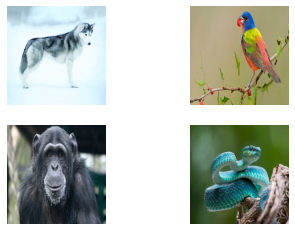

In [3]:
from tensorflow.keras.preprocessing import image

fig, axes = plt.subplots(nrows=2, ncols=2)

for i in range(4):
    img_path = './data/img%d.JPG'%i
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(2,2,i+1)
    plt.imshow(img);
    plt.axis('off');

## variable

예제 실행에서 사용하는 변수 정의

In [4]:
batch_size = 8
batched_input = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)

for i in range(batch_size):
    img_path = f'data/img{i%4}.JPG'
    img = image.load_img(img_path, target_size=(224, 224))
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    batched_input[i, :] = x
    
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

batched_input shape:  (8, 224, 224, 3)


## Define Function

예제 실행에서 사용하는 함수 정의

In [5]:
# test for frzen_graph
def predict_model(model):
    """
    Runs prediction on a single image and shows the result.
    input_saved_model (string): Name of the input model stored in the current dir
    """
    img_path = 'data/img0.JPG'  # Siberian_husky
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = tf.constant(x)
    
    frozen_graph_predictions = model(x)
    
    preds = frozen_graph_predictions[0].numpy()
    print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))

    plt.subplot(2,2,1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(decode_predictions(preds, top=3)[0][0][1])

In [6]:
# test for frzen_graph

def benchmark_model(model):    
    N_warmup_run = 50
    N_run = 1000
    elapsed_time = []
    
    for i in range(N_warmup_run):
        preds = model(batched_input)

    for i in range(N_run):
        start_time = time.time()
        preds = model(batched_input)
        end_time = time.time()

        elapsed_time = np.append(elapsed_time, end_time - start_time)
        if i % 50 == 0:
            print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

In [7]:
def predict_tftrt(saved_model_loaded):
    """
    Runs prediction on a single image and shows the result.
    input_saved_model (string): Name of the input model stored in the current dir
    """
    img_path = 'data/img0.JPG'  # Siberian_husky
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = tf.constant(x)
    
    infer = saved_model_loaded.signatures['serving_default']
    
    preds =  infer(x)['predictions'].numpy() 
    print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))
    plt.subplot(2,2,1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(decode_predictions(preds, top=3)[0][0][1])

In [8]:
def benchmark_tftrt(saved_model_loaded):
    infer = saved_model_loaded.signatures['serving_default']
    
    N_warmup_run = 50
    N_run = 1000
    elapsed_time = []
    
    for i in range(N_warmup_run):
        preds = infer(batched_input)

    for i in range(N_run):
        start_time = time.time()
        preds = infer(batched_input)
        end_time = time.time()

        elapsed_time = np.append(elapsed_time, end_time - start_time)
        if i % 50 == 0:
            print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

In [9]:
def get_dummy_images(batch_size = 32, img_shape = [224, 224, 3]):
    img=tf.random.uniform(shape=[batch_size] + img_shape, dtype=tf.float32)
    print("Generated input random images with shape (N, H, W, C) =", img.shape)
    return img

In [10]:
# save loaded model as frozen pb file
"""
frozen graph 는 모델을 고정한 (freeze) 형태입니다.
frozen graph 는 더 이상 학습이 불가하며, 모델의 구조와 가중치가 결합되어 있습니다.
크기가 줄고, 하나의 파일로 존재하며 다른 디바이스에 포팅할 때 주로 사용합니다. 
"""


def save_frozen_graph(saved_model_loaded, output_path):
    graph_func = saved_model_loaded.signatures['serving_default']
    
    full_model = tf.function(lambda x: graph_func(x))
    full_model = full_model.get_concrete_function(
            tf.TensorSpec(graph_func.inputs[0].shape, graph_func.inputs[0].dtype))

    frozen_func = convert_to_constants.convert_variables_to_constants_v2(full_model)
    frozen_func.graph.as_graph_def()
    
    # Save frozen graph from frozen ConcreteFunction to hard drive
    tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=output_path,
                  name="frozen_graph.pb",
                  as_text=False)

In [11]:
def load_frozen_graph(input_path):
    
    def wrap_frozen_graph(graph_def, inputs, outputs, print_graph=False):
        def _imports_graph_def():
            tf.compat.v1.import_graph_def(graph_def, name="")

        wrapped_import = tf.compat.v1.wrap_function(_imports_graph_def, [])
        import_graph = wrapped_import.graph

        if print_graph == True:
            print("-" * 50)
            print("Frozen model layers: ")
            layers = [op.name for op in import_graph.get_operations()]
            for layer in layers:
                print(layer)
            print("-" * 50)

        return wrapped_import.prune(
            tf.nest.map_structure(import_graph.as_graph_element, inputs),
            tf.nest.map_structure(import_graph.as_graph_element, outputs))

    # Load frozen graph using TensorFlow 1.x functions
    with tf.io.gfile.GFile(f'./{input_path}/frozen_graph.pb', 'rb') as f:
        graph_def = tf.compat.v1.GraphDef()
        loaded = graph_def.ParseFromString(f.read())

    # Wrap frozen graph to ConcreteFunctions
    frozen_func = wrap_frozen_graph(graph_def=graph_def,
                                    inputs=["x:0"],
                                    outputs=["Identity:0"],
                                    print_graph=False)
    
    return frozen_func

# Model test

## Keras resnet50 test

non-converted model 테스트
- **model save time**
    - TF2 save_model: 1.511 min
    - frozen graph: 1.278 min
- **loading time**: 
    - keras model: 1.063 min
    - frozen model: 1.06 min
- **Throughput**: 97 images/s
- **file size**
    ```
    360K    resnet50_saved_model/keras_metadata.pb
    4.0K    resnet50_saved_model/assets
    98M     resnet50_saved_model/variables/variables.data-00000-of-00001
    20K     resnet50_saved_model/variables/variables.index
    98M     resnet50_saved_model/variables
    4.0M    resnet50_saved_model/saved_model.pb
    103M    resnet50_saved_model
    ```

In [12]:
model = ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 11s 0us/step


40960/35363 [==================================] - 0s 1us/step
./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.55662084), ('n02109961', 'Eskimo_dog', 0.41737264), ('n02110063', 'malamute', 0.02095157)]
./data/img1.JPG - Predicted: [('n01820546', 'lorikeet', 0.30138966), ('n01537544', 'indigo_bunting', 0.16979544), ('n01828970', 'bee_eater', 0.16134165)]
./data/img2.JPG - Predicted: [('n02481823', 'chimpanzee', 0.5149866), ('n02480495', 'orangutan', 0.15896694), ('n02480855', 'gorilla', 0.15318145)]
./data/img3.JPG - Predicted: [('n01729977', 'green_snake', 0.41596174), ('n03627232', 'knot', 0.10065208), ('n01749939', 'green_mamba', 0.0670499)]


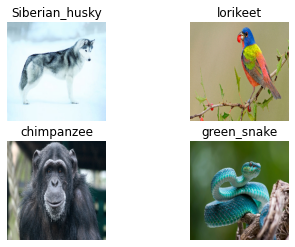

In [13]:
for i in range(4):
    img_path = './data/img%d.JPG'%i
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    # decode the results into a list of tuples (class, description, probability)
    # (one such list for each sample in the batch)
    print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))

    plt.subplot(2,2,i+1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(decode_predictions(preds, top=3)[0][0][1])

In [14]:
start_time = time.time()

# Save the entire model as a SavedModel.
model.save('resnet50_saved_model') 

end_time = time.time()
load_term = (end_time - start_time)/60
print(f'model save time: {load_term} min')

/home/keti/tf_2.5.0/lib/python3.6/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: resnet50_saved_model/assets
model save time: 1.449988337357839 min


In [15]:
# model load and check loading time

start_time = time.time()

saved_model_loaded = tf.keras.models.load_model('resnet50_saved_model')

end_time = time.time()
load_term = (end_time - start_time)
load_term = (load_term)/60
print(f'model load time: {load_term} min')

model load time: 1.1430468559265137 min


data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.55662084), ('n02109961', 'Eskimo_dog', 0.41737264), ('n02110063', 'malamute', 0.02095159)]


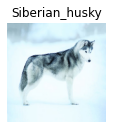

In [16]:
predict_tftrt(saved_model_loaded)

In [17]:
benchmark_tftrt(saved_model_loaded)

Step 0: 84.5ms
Step 50: 84.2ms
Step 100: 84.2ms
Step 150: 84.1ms
Step 200: 84.3ms
Step 250: 84.2ms
Step 300: 84.3ms
Step 350: 84.2ms
Step 400: 84.2ms
Step 450: 84.1ms
Step 500: 84.2ms
Step 550: 84.2ms
Step 600: 84.1ms
Step 650: 84.2ms
Step 700: 84.2ms
Step 750: 84.1ms
Step 800: 84.2ms
Step 850: 84.0ms
Step 900: 84.0ms
Step 950: 84.3ms
Throughput: 95 images/s


### frozen model

모델을 frozen graph 로 저장하고 로드하여 테스트

In [18]:
# check frozen model converting time

start_time = time.time()
save_frozen_graph(saved_model_loaded = saved_model_loaded, 
                  output_path='[frozen]resnet50_saved_model')
end_time = time.time()
load_term = (end_time - start_time)/60
print(f'frozen graph convert/save time: {load_term} min')

frozen graph convert/save time: 0.1526840329170227 min


In [19]:
# model load and check loading time

start_time = time.time()
frozen_func = load_frozen_graph(input_path = '[frozen]resnet50_saved_model')
end_time = time.time()
load_term = (end_time - start_time)/60
print(f'frozen graph load time: {load_term} min')

frozen graph load time: 0.09355489810307821 min


data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.55662125), ('n02109961', 'Eskimo_dog', 0.4173722), ('n02110063', 'malamute', 0.020951625)]


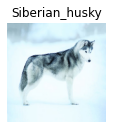

In [20]:
predict_model(frozen_func)

In [21]:
benchmark_model(frozen_func)

Step 0: 82.4ms
Step 50: 83.4ms
Step 100: 83.2ms
Step 150: 83.3ms
Step 200: 83.2ms
Step 250: 83.2ms
Step 300: 83.2ms
Step 350: 83.3ms
Step 400: 83.4ms
Step 450: 83.3ms
Step 500: 83.2ms
Step 550: 83.2ms
Step 600: 83.1ms
Step 650: 83.2ms
Step 700: 83.1ms
Step 750: 83.2ms
Step 800: 83.2ms
Step 850: 83.3ms
Step 900: 83.3ms
Step 950: 83.2ms
Throughput: 96 images/s


## TF_TRT Float32 Test

- saved model
    - loading time: 6.845 min
    - throughput: 549 images/s
- frozen graph
    - loading time: 8.6288 min
    - throughput: 550 images/s

### non build


In [22]:
def trt_convert(input_path, output_path, input_shapes, explicit_batch=False):
    
    conv_params = trt.TrtConversionParams(
        precision_mode=trt.TrtPrecisionMode.FP32)
    
    converter = trt.TrtGraphConverterV2(
       input_saved_model_dir = input_path, 
        conversion_params = conv_params)

    start_time = time.time()
    converter.convert()
    end_time = time.time()
    load_term = (end_time - start_time)/60
    print(f'model converting time {load_term} min')
    
    converter.save(output_path)

In [23]:
input_data =  get_dummy_images(batch_size = 8, img_shape = [224, 224, 3])

# measure TF-TRT converting time
start_time = time.time()

trt_convert(input_path = 'resnet50_saved_model', 
           output_path = 'resnet50_saved_model_TFTRT_FP32', 
           input_shapes = [[input_data.shape]])

end_time = time.time()
load_term = (end_time - start_time)/60
print(f'{load_term} min')

Generated input random images with shape (N, H, W, C) = (8, 224, 224, 3)
INFO:tensorflow:Linked TensorRT version: (8, 0, 1)
INFO:tensorflow:Loaded TensorRT version: (8, 0, 1)
model converting time 9.998705498377483 min
INFO:tensorflow:Could not find TRTEngineOp_0_0 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP32/assets
13.502420365810394 min


In [24]:
start_time = time.time()


saved_model_loaded = tf.saved_model.load('resnet50_saved_model_TFTRT_FP32', 
                                         tags=[tag_constants.SERVING])
end_time = time.time()
load_term = (end_time - start_time)/60
print(f'{load_term} min')

6.2528704086939495 min


data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5566208), ('n02109961', 'Eskimo_dog', 0.4173726), ('n02110063', 'malamute', 0.02095161)]


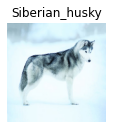

In [25]:
predict_tftrt(saved_model_loaded)

In [26]:
benchmark_tftrt(saved_model_loaded)

Step 0: 48.6ms
Step 50: 48.7ms
Step 100: 49.0ms
Step 150: 48.9ms
Step 200: 48.8ms
Step 250: 48.7ms
Step 300: 48.8ms
Step 350: 49.0ms
Step 400: 48.7ms
Step 450: 48.7ms
Step 500: 48.7ms
Step 550: 48.9ms
Step 600: 48.9ms
Step 650: 48.6ms
Step 700: 48.8ms
Step 750: 48.9ms
Step 800: 48.6ms
Step 850: 48.8ms
Step 900: 48.7ms
Step 950: 48.8ms
Throughput: 164 images/s


#### frozen graph

In [27]:
# frozen graph save time check
start_time = time.time()
save_frozen_graph(saved_model_loaded = saved_model_loaded, 
                  output_path = '[frozen]resnet50_saved_model_TFTRT_FP32')
end_time = time.time()
load_term = (end_time - start_time)/60
print(f'save_frozen_graph: {load_term} min')

save_frozen_graph: 15.483416684468587 min


In [28]:
# model load and check loading time

start_time = time.time()

# frozen_func = load_frozen_model(output_saved_model_dir)
frozen_func = load_frozen_graph('[frozen]resnet50_saved_model_TFTRT_FP32')

end_time = time.time()

load_term = (end_time - start_time)/60
print(f'load_frozen_graph: {load_term} min')

load_frozen_graph: 8.180434918403625 min


data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5566212), ('n02109961', 'Eskimo_dog', 0.41737214), ('n02110063', 'malamute', 0.020951584)]


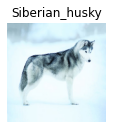

In [29]:
predict_model(frozen_func)

In [30]:
benchmark_model(frozen_func)

Step 0: 48.7ms
Step 50: 49.0ms
Step 100: 48.9ms
Step 150: 48.9ms
Step 200: 48.9ms
Step 250: 48.8ms
Step 300: 49.0ms
Step 350: 48.7ms
Step 400: 49.1ms
Step 450: 48.8ms
Step 500: 48.5ms
Step 550: 48.7ms
Step 600: 48.8ms
Step 650: 48.9ms
Step 700: 49.1ms
Step 750: 48.7ms
Step 800: 48.9ms
Step 850: 48.9ms
Step 900: 48.9ms
Step 950: 48.9ms
Throughput: 164 images/s


### build included


- build 함수는 변환된 함수 (converter.convert()) 를 최적화한다. 
- TensorRT 엔진을 구축함으로써. 이는 사용자가 런타임 전에 최적화를 수행하려는 경우에 유용합니다. 
- 최적화는 인수에서 받은 입력 데이터를 사용하여 변환된 함수에 대한 추론을 실행하여 수행됩니다. 입력_fn. 이 인수는 입력 데이터를 목록 또는 튜플로 생성하는 생성기 함수입니다.
- 따라서 최적화를 한 이후에는 batch size 을 일정하게 해야 성능을 최적화 할 수 있다
- float32, float16 의 경우 실행중 오류가 발생하는 경우가 있다. 현재는 RAM 오류로 추정중

In [11]:
def trt_convert(input_path, output_path, input_shapes, explicit_batch=False):
    
    conv_params = trt.TrtConversionParams(
        precision_mode=trt.TrtPrecisionMode.FP32)
    
    converter = trt.TrtGraphConverterV2(
       input_saved_model_dir = input_path, 
        conversion_params = conv_params)

    start_time = time.time()
    converter.convert()
    end_time = time.time()
    load_term = (end_time - start_time)/60
    print(f'model converting time {load_term} min')
    
    def input_fn():
        for shapes in input_shapes:
            # return a list of input tensors
            yield [np.ones(shape=x).astype(np.float32) for x in shapes]
            
    start_time = time.time()
    converter.build(input_fn)
    end_time = time.time()
    load_term = (end_time - start_time)/60
    print(f'model build time {load_term} min')
    
    converter.save(output_path)

In [ ]:
input_data =  get_dummy_images(batch_size = 8, img_shape = [224, 224, 3])

trt_convert(input_path = 'resnet50_saved_model', 
            output_path = 'resnet50_saved_model_TFTRT_FP32_build', 
            input_shapes = [[input_data.shape]])

Generated input random images with shape (N, H, W, C) = (8, 224, 224, 3)
INFO:tensorflow:Linked TensorRT version: (8, 0, 1)
INFO:tensorflow:Loaded TensorRT version: (8, 0, 1)


In [26]:
start_time = time.time()

saved_model_loaded = tf.saved_model.load('resnet50_saved_model_TFTRT_FP32_build', 
                                         tags=[tag_constants.SERVING])
end_time = time.time()
load_term = (end_time - start_time)/60
print(f'{load_term} min')

6.499908709526062 min


data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5566203), ('n02109961', 'Eskimo_dog', 0.41737306), ('n02110063', 'malamute', 0.020951627)]


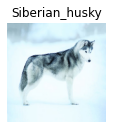

In [34]:
predict_tftrt(saved_model_loaded)

In [35]:
benchmark_tftrt(saved_model_loaded)

Step 0: 51.3ms
Step 50: 51.3ms
Step 100: 51.2ms
Step 150: 51.2ms
Step 200: 51.1ms
Step 250: 51.2ms
Step 300: 51.2ms
Step 350: 51.2ms
Step 400: 51.2ms
Step 450: 51.2ms
Step 500: 51.2ms
Step 550: 51.1ms
Step 600: 51.3ms
Step 650: 51.3ms
Step 700: 51.0ms
Step 750: 51.2ms
Step 800: 51.2ms
Step 850: 51.0ms
Step 900: 51.1ms
Step 950: 51.2ms
Throughput: 156 images/s


#### frozen graph

In [30]:
# frozen graph save time check
start_time = time.time()
save_frozen_graph(saved_model_loaded=saved_model_loaded, 
                  output_path = '[frozen]resnet50_saved_model_TFTRT_FP32_build')
end_time = time.time()
load_term = (end_time - start_time)/60
print(f'frozen graph save time: {load_term} min')

frozen graph save time: 16.338901821772257 min


In [31]:
# model load and check loading time

start_time = time.time()

# frozen_func = load_frozen_model(output_saved_model_dir)
frozen_func = load_frozen_graph('[frozen]resnet50_saved_model_TFTRT_FP32_build')
end_time = time.time()
load_term = (end_time - start_time)/60
print(f'frozen graph loading time: {load_term} min')

frozen graph loading time: 9.221751594543457 min


data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5566203), ('n02109961', 'Eskimo_dog', 0.41737306), ('n02110063', 'malamute', 0.020951627)]


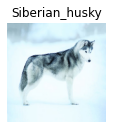

In [32]:
predict_model(frozen_func)

In [33]:
benchmark_model(frozen_func)

Step 0: 51.5ms
Step 50: 51.1ms
Step 100: 51.3ms
Step 150: 51.3ms
Step 200: 51.3ms
Step 250: 51.3ms
Step 300: 51.3ms
Step 350: 51.1ms
Step 400: 51.1ms
Step 450: 51.1ms
Step 500: 51.0ms
Step 550: 51.1ms
Step 600: 51.1ms
Step 650: 51.2ms
Step 700: 51.0ms
Step 750: 51.2ms
Step 800: 51.8ms
Step 850: 51.2ms
Step 900: 51.1ms
Step 950: 51.0ms
Throughput: 156 images/s


## TF-TRT Float16 Test

- saved model
    - loading time: 6.845 min
    - throughput: 549 images/s
- frozen graph
    - loading time: 8.6288 min
    - throughput: 550 images/s


### non-build

In [10]:
def trt_convert(input_path, output_path, input_shapes, explicit_batch=False):
    
    conv_params = trt.TrtConversionParams(
        precision_mode=trt.TrtPrecisionMode.FP16)
    
    converter = trt.TrtGraphConverterV2(
       input_saved_model_dir = input_path, 
        conversion_params = conv_params)

    start_time = time.time()
    converter.convert()
    end_time = time.time()
    load_term = (end_time - start_time)/60
    print(f'model converting time {load_term} min')
    
    converter.save(output_path)

In [11]:
input_data =  get_dummy_images(batch_size = 8, img_shape = [224, 224, 3])

trt_convert(input_path = 'resnet50_saved_model', 
            output_path = 'resnet50_saved_model_TFTRT_FP16', 
            input_shapes = [[input_data.shape]])

Generated input random images with shape (N, H, W, C) = (8, 224, 224, 3)
INFO:tensorflow:Linked TensorRT version: (8, 0, 1)
INFO:tensorflow:Loaded TensorRT version: (8, 0, 1)
model converting time 8.36376162370046 min
INFO:tensorflow:Could not find TRTEngineOp_0_6 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_7 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_1 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_2 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_0 in TF-TRT cache. This can happen if build() is 

In [11]:
start_time = time.time()
saved_model_loaded = tf.saved_model.load('resnet50_saved_model_TFTRT_FP16', 
                                         tags=[tag_constants.SERVING])
end_time = time.time()
load_term = (end_time - start_time)/60
print(f'{load_term} min')

6.843931420644124 min


data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5507911), ('n02109961', 'Eskimo_dog', 0.42230618), ('n02110063', 'malamute', 0.021692801)]


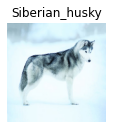

In [12]:
predict_tftrt(saved_model_loaded)

In [13]:
benchmark_tftrt(saved_model_loaded)

Step 0: 21.4ms
Step 50: 20.8ms
Step 100: 21.0ms
Step 150: 21.0ms
Step 200: 21.0ms
Step 250: 21.1ms
Step 300: 20.9ms
Step 350: 20.9ms
Step 400: 21.0ms
Step 450: 21.0ms
Step 500: 20.9ms
Step 550: 20.9ms
Step 600: 21.0ms
Step 650: 21.0ms
Step 700: 21.0ms
Step 750: 21.1ms
Step 800: 21.0ms
Step 850: 21.0ms
Step 900: 21.0ms
Step 950: 20.9ms
Throughput: 381 images/s


#### Frozen-graph test

In [14]:
# frozen graph save time check
start_time = time.time()
save_frozen_graph(saved_model_loaded=saved_model_loaded, 
                  output_path = '[frozen]resnet50_saved_model_TFTRT_FP16')
end_time = time.time()
load_term = (end_time - start_time)/60
print(f'frozen graph save time: {load_term} min')

frozen graph save time: 15.044377493858338 min


In [10]:
# model load and check loading time

start_time = time.time()
# frozen_func = load_frozen_model(output_saved_model_dir)
frozen_func = load_frozen_graph('[frozen]resnet50_saved_model_TFTRT_FP16')

end_time = time.time()
load_term = (end_time - start_time)/60
print(f'{load_term} min')

8.9001269419988 min


data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.55078125), ('n02109961', 'Eskimo_dog', 0.42211914), ('n02110063', 'malamute', 0.022033691)]


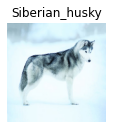

In [13]:
predict_model(frozen_func)

In [14]:
benchmark_model(frozen_func)

Step 0: 22.0ms
Step 50: 21.0ms
Step 100: 21.1ms
Step 150: 21.0ms
Step 200: 21.0ms
Step 250: 21.0ms
Step 300: 20.9ms
Step 350: 21.0ms
Step 400: 20.9ms
Step 450: 20.8ms
Step 500: 20.9ms
Step 550: 20.9ms
Step 600: 20.8ms
Step 650: 21.0ms
Step 700: 20.9ms
Step 750: 20.9ms
Step 800: 20.9ms
Step 850: 20.8ms
Step 900: 20.7ms
Step 950: 20.8ms
Throughput: 383 images/s


### build

In [15]:
def trt_convert(input_path, output_path, input_shapes, explicit_batch=False):
    
    conv_params = trt.TrtConversionParams(
        precision_mode=trt.TrtPrecisionMode.FP16)
    
    converter = trt.TrtGraphConverterV2(
       input_saved_model_dir = input_path, 
        conversion_params = conv_params)


    start_time = time.time()
    converter.convert()
    end_time = time.time()
    load_term = (end_time - start_time)/60
    print(f'model converting time {load_term} min')
    
    
    def input_fn():
        for shapes in input_shapes:
            # return a list of input tensors
            yield [np.ones(shape=x).astype(np.float32) for x in shapes]
            
    start_time = time.time()
    converter.build(input_fn)
    end_time = time.time()
    load_term = (end_time - start_time)/60
    print(f'model build time {load_term} min')
    
    converter.save(output_path)

In [16]:
input_data =  get_dummy_images(batch_size = 8, img_shape = [224, 224, 3])

trt_convert(input_path = 'resnet50_saved_model', 
            output_path = 'resnet50_saved_model_TFTRT_FP16_build', 
            input_shapes = [[input_data.shape]])

Generated input random images with shape (N, H, W, C) = (8, 224, 224, 3)
INFO:tensorflow:Linked TensorRT version: (8, 0, 1)
INFO:tensorflow:Loaded TensorRT version: (8, 0, 1)
model converting time 9.408748976389568 min
model build time 0.03215705156326294 min
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP16_build/assets


In [11]:
start_time = time.time()
saved_model_loaded = tf.saved_model.load('resnet50_saved_model_TFTRT_FP16_build', 
                                         tags=[tag_constants.SERVING])
end_time = time.time()
load_term = (end_time - start_time)/60
print(f'{load_term} min')

6.869127261638641 min


data/img0.JPG - Predicted: [('n09229709', 'bubble', 0.24169922), ('n03041632', 'cleaver', 0.16882324), ('n04332243', 'strainer', 0.066101074)]


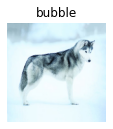

In [18]:
predict_tftrt(saved_model_loaded)

In [19]:
benchmark_tftrt(saved_model_loaded)

Step 0: 20.4ms
Step 50: 21.0ms
Step 100: 21.0ms
Step 150: 20.9ms
Step 200: 21.1ms
Step 250: 21.0ms
Step 300: 21.1ms
Step 350: 21.0ms
Step 400: 21.0ms
Step 450: 21.0ms
Step 500: 21.0ms
Step 550: 21.0ms
Step 600: 20.9ms
Step 650: 20.9ms
Step 700: 21.1ms
Step 750: 20.9ms
Step 800: 20.9ms
Step 850: 20.9ms
Step 900: 20.9ms
Step 950: 21.0ms
Throughput: 382 images/s


#### frozen graph

In [12]:
# frozen graph save time check
start_time = time.time()
save_frozen_graph(saved_model_loaded=saved_model_loaded, 
                  output_path = '[frozen]resnet50_saved_model_TFTRT_FP16_build')
end_time = time.time()
load_term = (end_time - start_time)/60
print(f'frozen graph save time: {load_term} min')

frozen graph save time: 16.008945488929747 min


In [13]:
# model load and check loading time

start_time = time.time()
# frozen_func = load_frozen_model(output_saved_model_dir)
frozen_func = load_frozen_graph('[frozen]resnet50_saved_model_TFTRT_FP16_build')

end_time = time.time()
load_term = (end_time - start_time)/60
print(f'{load_term} min')

8.074269553025564 min


data/img0.JPG - Predicted: [('n09229709', 'bubble', 0.24169922), ('n03041632', 'cleaver', 0.16882324), ('n04332243', 'strainer', 0.066101074)]


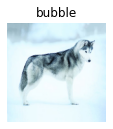

In [14]:
predict_model(frozen_func)

In [15]:
benchmark_model(frozen_func)

Step 0: 21.7ms
Step 50: 21.3ms
Step 100: 21.4ms
Step 150: 21.3ms
Step 200: 21.3ms
Step 250: 21.3ms
Step 300: 21.3ms
Step 350: 21.1ms
Step 400: 21.1ms
Step 450: 21.2ms
Step 500: 21.2ms
Step 550: 21.3ms
Step 600: 21.3ms
Step 650: 21.3ms
Step 700: 21.3ms
Step 750: 21.2ms
Step 800: 21.2ms
Step 850: 21.2ms
Step 900: 21.3ms
Step 950: 21.3ms
Throughput: 376 images/s


## TF-TRT Int8 test

variable, function 정의 필요 (`batched_input`, `get_dummy_images`)

-----

- saved model
    - loading time: 11.2650 min
    - throughput: 910 images/s
- frozen graph
    - loading time: 8.615 min
    - throughput: 926 images/s

In [4]:
# batched_input 은 전달 인수로 넣으려 했으나 오류 발생
# 나중에 시도

def int8_trt_convert(input_path, output_path, input_shapes, explicit_batch=False):
    conv_params=trt.TrtConversionParams(
        precision_mode=trt.TrtPrecisionMode.INT8,
        use_calibration=False)
    
    converter = trt.TrtGraphConverterV2(
        input_saved_model_dir=input_path, 
        conversion_params=conv_params,
        use_dynamic_shape=explicit_batch,
        dynamic_shape_profile_strategy='Optimal')

      
    def calibration_input_fn():
        yield (batched_input, )
    converter.convert(calibration_input_fn = calibration_input_fn)
    
    def input_fn():
        for shapes in input_shapes:
            # return a list of input tensors
            yield [np.ones(shape=x).astype(np.float32) for x in shapes]

    converter.build(input_fn)
    converter.save(output_path)

In [ ]:
input_data =  get_dummy_images(batch_size = 8, img_shape = [224, 224, 3])

# measure TF-TRT converting time
start_time = time.time()

int8_trt_convert(input_path='resnet50_saved_model', 
                 output_path='resnet50_saved_model_TFTRT_INT8_build', 
                 input_shapes = [[input_data.shape]],
                 explicit_batch=False)

end_time = time.time()
load_term = (end_time - start_time)/60
print(f'{load_term} min')

Generated input random images with shape (N, H, W, C) = (8, 224, 224, 3)
INFO:tensorflow:Linked TensorRT version: (8, 0, 1)
INFO:tensorflow:Loaded TensorRT version: (8, 0, 1)


In [10]:
# model load and check loading time

start_time = time.time()
saved_model_loaded = tf.keras.models.load_model('resnet50_saved_model_TFTRT_INT8_build')
end_time = time.time()

load_term = (end_time - start_time)/60
print(f'{load_term} min')

10.496431748072306 min


data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5962649), ('n02109961', 'Eskimo_dog', 0.37307543), ('n02110063', 'malamute', 0.025809996)]


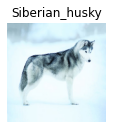

In [14]:
predict_tftrt(saved_model_loaded)

In [13]:
benchmark_tftrt(saved_model_loaded)

Step 0: 17.0ms
Step 50: 17.4ms
Step 100: 17.0ms
Step 150: 17.2ms
Step 200: 17.0ms
Step 250: 17.1ms
Step 300: 17.3ms
Step 350: 17.0ms
Step 400: 17.1ms
Step 450: 16.9ms
Step 500: 17.1ms
Step 550: 17.1ms
Step 600: 17.0ms
Step 650: 17.2ms
Step 700: 17.0ms
Step 750: 17.1ms
Step 800: 16.9ms
Step 850: 17.1ms
Step 900: 17.1ms
Step 950: 17.0ms
Throughput: 468 images/s


### frozen graph test

In [17]:
start_time = time.time()
save_frozen_graph(saved_model_loaded, 
                  output_path = '[frozen]resnet50_saved_model_TFTRT_INT8_build')
end_time = time.time()
load_term = (end_time - start_time)/60
print(f'{load_term} min')

16.83028330405553 min


In [ ]:
# model load and check loading time

start_time = time.time()
frozen_func = load_frozen_graph('[frozen]resnet50_saved_model_TFTRT_INT8_build')
end_time = time.time()

load_term = (end_time - start_time)/60
print(f'{load_term} min')

/home/keti/workspace/venv/src/tftrt-resnet/[GPU] tftrt-resnet-image-classification/data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.61683357), ('n02109961', 'Eskimo_dog', 0.35315925), ('n02110063', 'malamute', 0.025128495)]


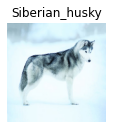

In [16]:
predict_model(frozen_func)

In [17]:
benchmark_model(frozen_func)

Step 0:  9.0ms
Step 50:  8.6ms
Step 100:  8.8ms
Step 150:  8.6ms
Step 200:  8.7ms
Step 250:  8.7ms
Step 300:  8.6ms
Step 350:  8.6ms
Step 400:  8.6ms
Step 450:  8.6ms
Step 500:  8.7ms
Step 550:  8.6ms
Step 600:  8.6ms
Step 650:  8.6ms
Step 700:  8.6ms
Step 750:  8.6ms
Step 800:  8.6ms
Step 850:  8.7ms
Step 900:  8.7ms
Step 950:  8.6ms
Throughput: 926 images/s
